In [238]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from datasets import load_dataset

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Dropping duplicating rows
df_unique = df.drop_duplicates().copy()

# Data cleaning
df_unique['job_posted_date'] = pd.to_datetime(df_unique['job_posted_date'])
df_unique['job_skills'] = df_unique['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [239]:
# Filtering the data for Data analyst job postings located in US
df_DA_US = df_unique[(df_unique['job_title_short'] == 'Data Analyst') & (df_unique['job_country'] == 'United States')].copy()

# Removing the data with NaN in salary_year_avg column in the filtered data
df_DA_US = df_DA_US.dropna(subset='salary_year_avg')

# Exploding the data to single out each skills
df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg','job_skills']].head()

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [240]:
len(df_DA_US)

4349

In [241]:
# Grouping the dataset by skills and finding out the count of each skill and also the median salary
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count', ascending=False)

# Renaming the count and median columns
df_DA_skills = df_DA_skills.rename(columns={'count':'skill_count', 'median' : 'median_salary'})

# Calculating the total number of Data analyst job postings in US with salary mentioned.
DA_job_count = len(df_DA_US)

# Creating a new column with each skills percentage inclusiion in data analyst job postings in US
df_DA_skills['skill_percent'] = df_DA_skills['skill_count']/DA_job_count*100


In [242]:
skill_limit = 5
df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

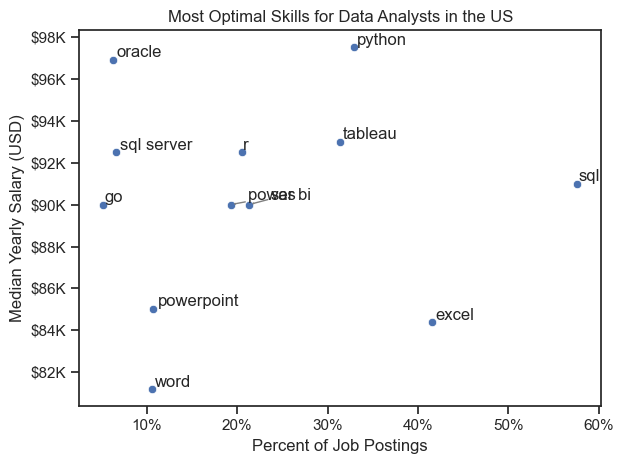

In [243]:
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

sns.scatterplot(data=df_DA_skills_high_demand, x=df_DA_skills_high_demand['skill_percent'], y=df_DA_skills_high_demand['median_salary'])

texts=[]
for i,x in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i],df_DA_skills_high_demand['median_salary'].iloc[i],x))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.xlabel('Percent of Job Postings')
plt.ylabel('Median Yearly Salary (USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.tight_layout()
plt.show()

In [244]:
df_technology = df_unique['job_type_skills'].copy()

# Remove duplicates
df_technology = df_technology.drop_duplicates()

# Remove NaN values
df_technology = df_technology.dropna()

In [245]:
technology_dict = {}

for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value


In [246]:
# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [247]:
type(technology_dict)

dict

In [248]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns = ['technology','skill'])

In [249]:
df_technology = df_technology.explode('skill')

In [250]:
df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2507,91000.00,57.645436
excel,1808,84392.00,41.572775
python,1431,97500.00,32.904116
tableau,1363,93000.00,31.340538
sas,926,90000.00,21.292251
r,893,92500.00,20.533456
power bi,838,90000.00,19.268797
powerpoint,462,85000.00,10.623132
word,461,81194.75,10.600138


In [251]:
df_plot = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skill')

In [252]:
i = df_plot[(df_plot['skill']=='sas') & (df_plot['technology']=='analyst_tools')].index

df_plot = df_plot.drop(i)

df_plot

,skill_count,median_salary,skill_percent,technology,skill
0,2507,91000.00,57.645436,programming,sql
1,1808,84392.00,41.572775,analyst_tools,excel
2,1431,97500.00,32.904116,programming,python
3,1363,93000.00,31.340538,analyst_tools,tableau
5,926,90000.00,21.292251,programming,sas
6,893,92500.00,20.533456,programming,r
7,838,90000.00,19.268797,analyst_tools,power bi
8,462,85000.00,10.623132,analyst_tools,powerpoint
9,461,81194.75,10.600138,analyst_tools,word
10,286,92500.00,6.576224,databases,sql server


In [253]:
df_plot = df_plot.set_index('skill')

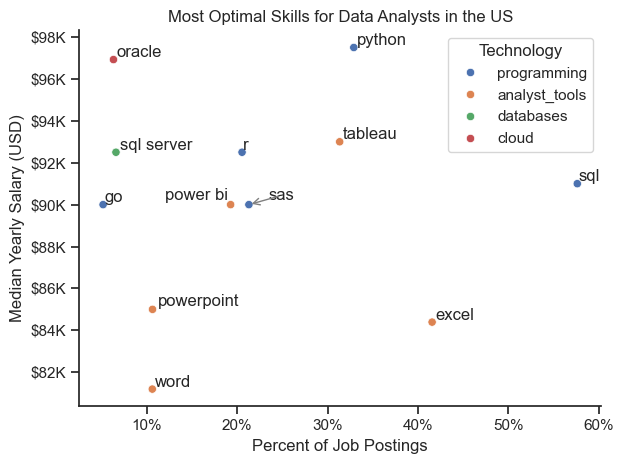

In [290]:
from cgitb import text
from turtle import color
from matplotlib.patches import ArrowStyle
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

sns.set_theme(style='ticks')
ax= sns.scatterplot(data=df_plot, x=df_plot['skill_percent'], y=df_plot['median_salary'], hue=df_plot['technology'])
sns.despine()
texts=[]
for i, txt in enumerate(df_plot.index):
    texts.append(plt.text(df_plot['skill_percent'].iloc[i], df_plot['median_salary'].iloc[i] , txt))

adjust_text(texts,expand_points=(3,3),force_text=(1,1), arrowprops = dict(arrowstyle = '->', color='gray'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.xlabel('Percent of Job Postings')
plt.ylabel('Median Yearly Salary (USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')
plt.tight_layout()
plt.show()